<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    with open(site_freq_path, 'rb') as freq:
        dic = pickle.load(freq)
    listcsv = glob(path_to_csv_files + '\*.csv')
    data = pd.DataFrame()
    rows = 0
    y_users = []
    for i, user in enumerate(listcsv):
        userid = int(user.split('\\')[-1][4:8])
        d = pd.read_csv(user)
        session = d.site.values
        session = np.array([dic[i][0] for i in session])
        time = d.timestamp.astype('datetime64[ns]').apply(lambda ts: 
                                                      ts.hour).astype('int').values
        dow = d.timestamp.astype('datetime64[ns]').apply(lambda ts: 
                                                      ts.isoweekday()).astype('int').values
        total = d.timestamp.astype('datetime64[ns]').apply(lambda ts: 
                                                      ts.timestamp()).astype('int').values
        k = (len(session) - 1) // window_size + 1
        rows += k
        a = np.zeros(len(feature_names))
        for j in range(k):
            s = session[j*window_size: j*window_size + session_length]
            unique_sites = np.unique(s).size
            t = time[j*window_size: j*window_size + session_length]
            w = dow[j*window_size: j*window_size + session_length]
            tot = total[j*window_size: j*window_size + session_length]
            session_timespan = tot.max() - tot.min()
            start_hour = t.min()
            day_of_week = w.min() - 1
            tot = tot[1:] - tot[:-1]
            if s.size < session_length:
                b = s.size
                s = np.hstack((s, [0]*(session_length - b)))
                tot = np.hstack((tot, [0]*(session_length - b)))
            a = np.vstack((a , np.hstack((s, tot, session_timespan, unique_sites, start_hour, day_of_week, userid))))
        data = pd.concat([data, pd.DataFrame(a[1:,:])]).astype('int')
    data.columns = feature_names
    data.index = np.arange(data.shape[0])
    return data

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,11,6,9,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,5,5,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,6,10,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [5]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 7.06 s


In [6]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,576,134,3,134,134,3,134,204,134,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,419,193,703,255,134,31,399,3766,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,294,419,339,899,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,481,4476,481,55,55,55,55,966,202,123,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,348,55,5,4862,259,212,3825,2265,704,2265,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [7]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 1min 18s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [8]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [89]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [90]:
new_features_10users['session_timespan'].median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [98]:
dow = ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс']
dow[int(new_features_10users['day_of_week'].median())]

'ср'

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [92]:
new_features_150users['start_hour'].median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [93]:
new_features_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [9]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [10]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

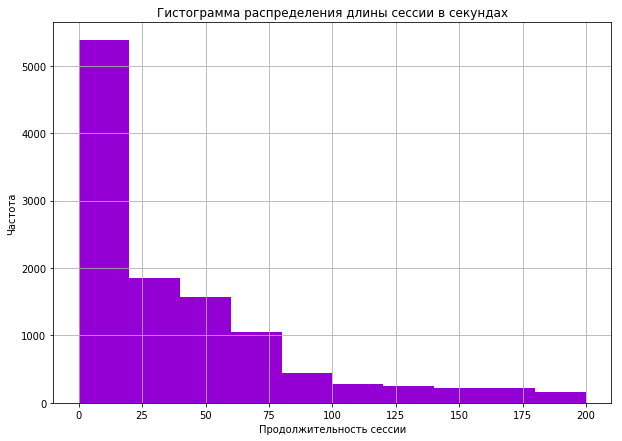

In [42]:
plt.figure(figsize=(10,7))
ax = train_data_10users['session_timespan'].hist(range = (0, 200), color='darkviolet')
plt.xlabel('Продолжительность сессии')
plt.ylabel('Частота')
plt.title('Гистограмма распределения длины сессии в секундах')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

In [26]:
np.arange(.5, 11, 1)

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5])

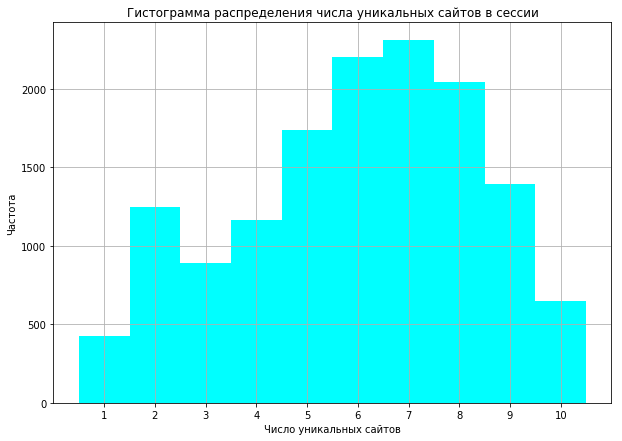

In [43]:
plt.figure(figsize=(10,7))
ax = train_data_10users['#unique_sites'].hist(color='aqua', bins=np.arange(.5, 11, 1))
plt.xlabel('Число уникальных сайтов')
plt.ylabel('Частота')
plt.gca().set(xticks = np.arange(1, 11))
plt.title('Гистограмма распределения числа уникальных сайтов в сессии')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

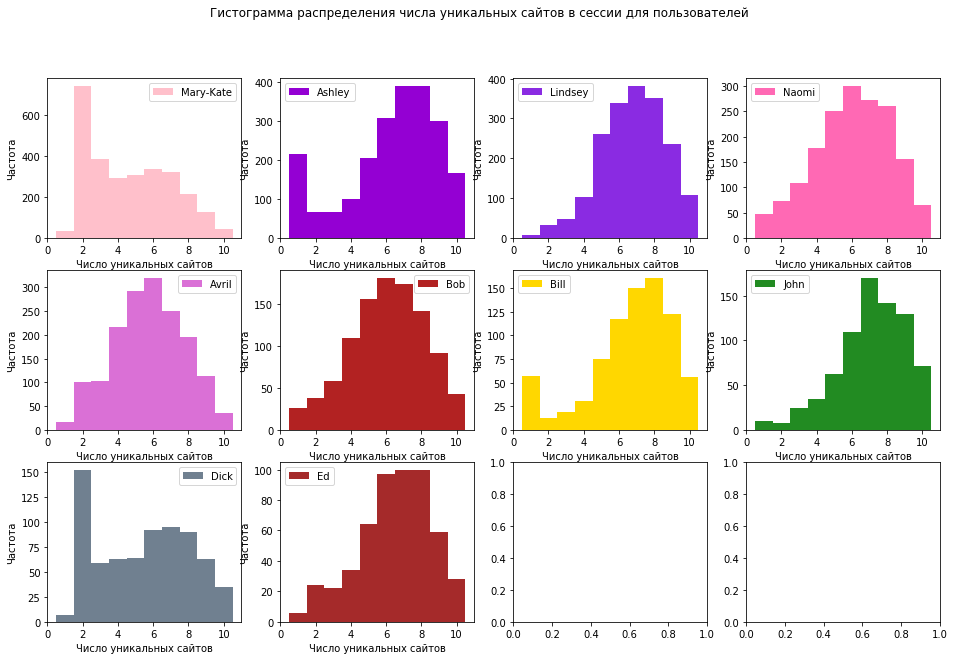

In [46]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.suptitle('Гистограмма распределения числа уникальных сайтов в сессии для пользователей')
for ax, name in zip(axes.flat[:10], color_dic.keys()):
    ax.hist(train_data_10users[train_data_10users['target'] == name]['#unique_sites'], 
            color=color_dic[name], label=name, bins=np.arange(.5, 11, 1))
    ax.set_xlabel('Число уникальных сайтов')
    ax.set_ylabel('Частота')
    ax.legend()
plt.show()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

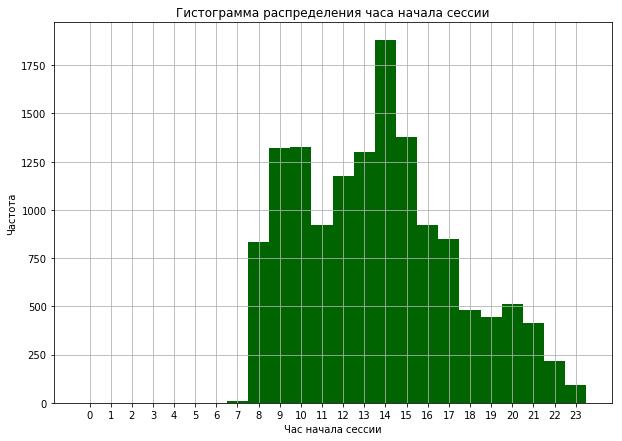

In [47]:
plt.figure(figsize=(10,7))
ax = train_data_10users['start_hour'].hist(color='darkgreen', bins=np.arange(-.5, 24, 1))
plt.xlabel('Час начала сессии')
plt.ylabel('Частота')
plt.gca().set(xticks = np.arange(0, 24))
plt.title('Гистограмма распределения часа начала сессии')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

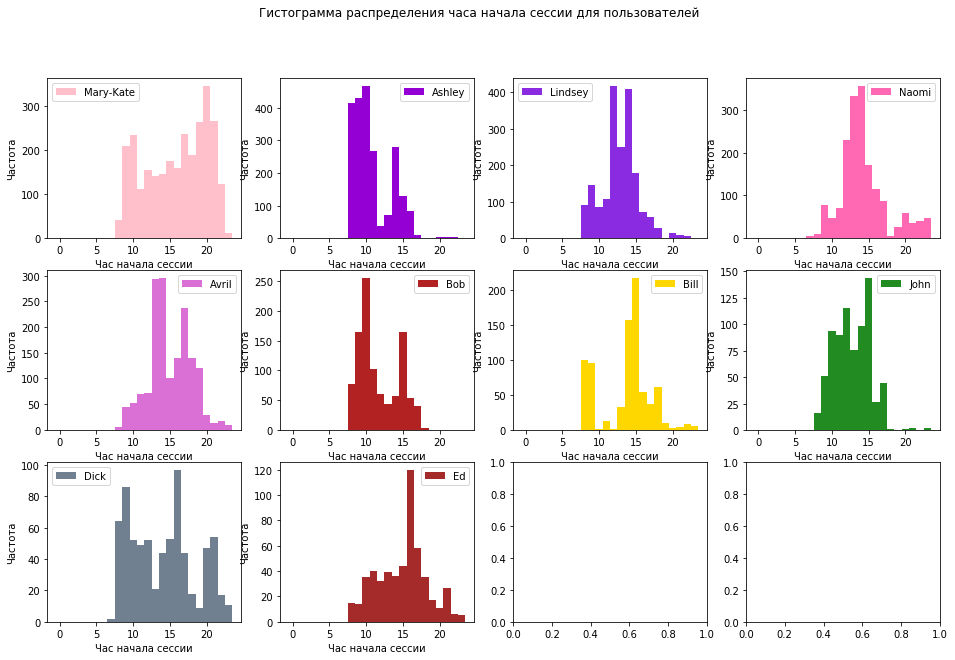

In [48]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.suptitle('Гистограмма распределения часа начала сессии для пользователей')
for ax, name in zip(axes.flat[:10], color_dic.keys()):
    ax.hist(train_data_10users[train_data_10users['target'] == name]['start_hour'], 
            color=color_dic[name], label=name, bins=np.arange(-.5, 24, 1))
    ax.set_xlabel('Час начала сессии')
    ax.set_ylabel('Частота')
    ax.legend()
plt.show()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

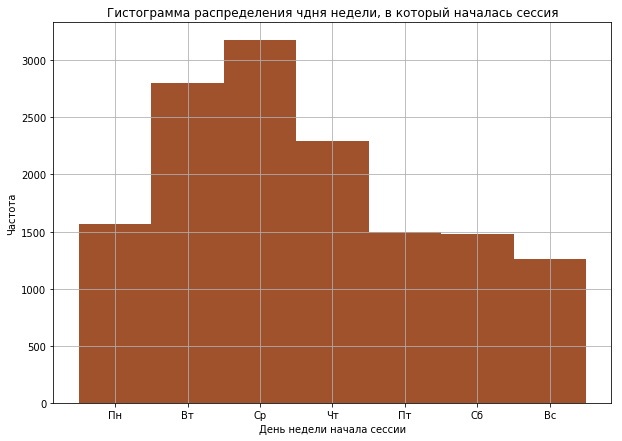

In [50]:
plt.figure(figsize=(10,7))
ax = train_data_10users['day_of_week'].hist(color='sienna', bins=np.arange(-.5, 7, 1))
plt.xlabel('День недели начала сессии')
plt.ylabel('Частота')
plt.gca().set(xticklabels=['nul', 'Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.title('Гистограмма распределения чдня недели, в который началась сессия')
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

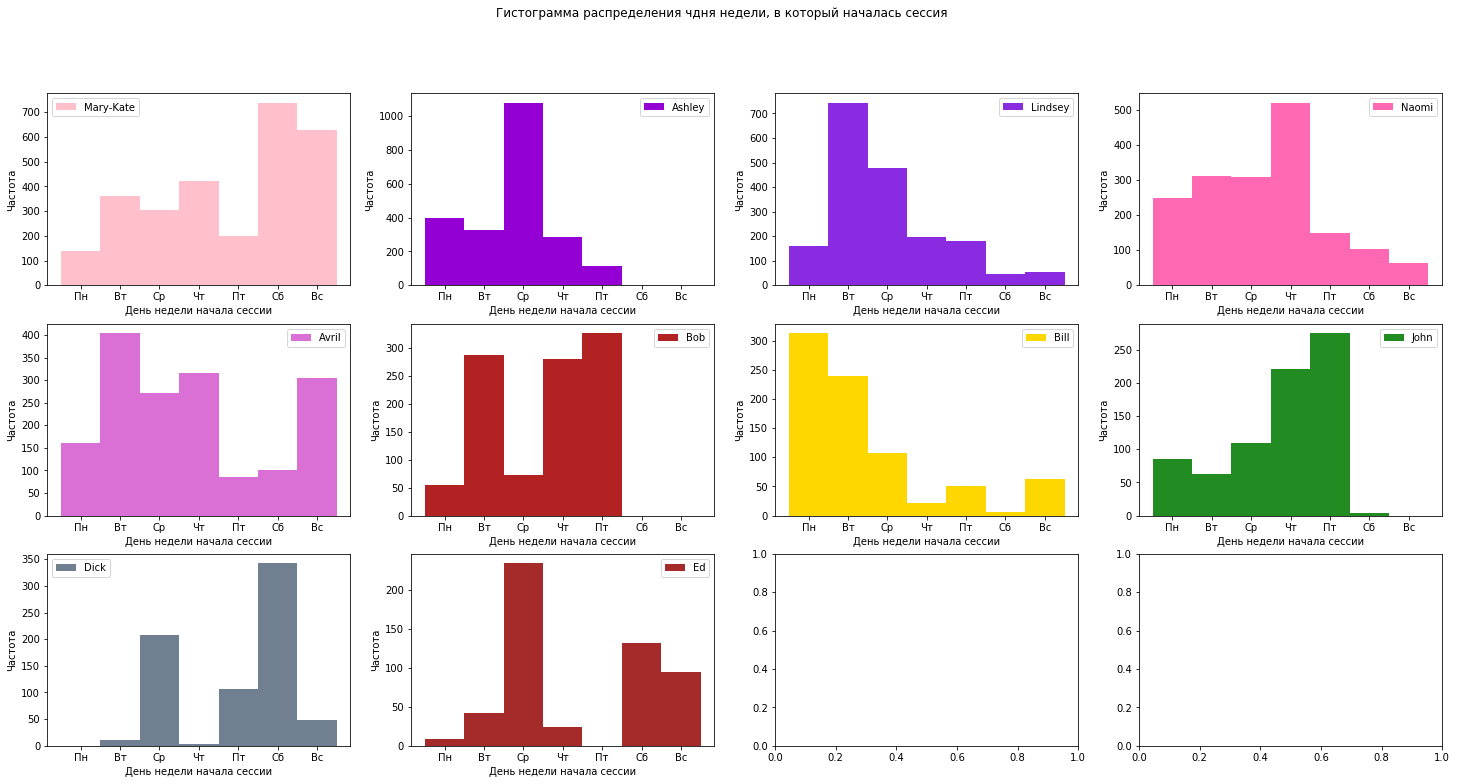

In [51]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(25, 12))
plt.suptitle('Гистограмма распределения чдня недели, в который началась сессия')
for ax, name in zip(axes.flat[:10], color_dic.keys()):
    ax.hist(train_data_10users[train_data_10users['target'] == name]['day_of_week'], 
            color=color_dic[name], label=name, bins=np.arange(-.5, 7, 1))
    ax.set_xlabel('День недели начала сессии')
    ax.set_ylabel('Частота')
    ax.set_xticklabels(labels = ['nul', 'Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    ax.legend()
plt.show()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

John: чаще всего число уникальных сайтов относительно высокое, вечером почти не начинает сеанс, не начинает активно сеанс в выходные дни.
Bob: чаще всего число уникальных сайтов относительно среднее, вечером и в выходные не начинает сеанс.
Ashley: чаще всего число уникальных сайтов относительно высокое, однако много сессий с одним уникальным сайтом, вечером и в выходные почти не начинает сеанс.
Bill: чаще всего число уникальных сайтов относительно высокое, однако много сессий с одним уникальным сайтом, в основном, начинает сеанс немного позже обеда часов и в начале недели. 
Dick: чаще всего число уникальных сайтов относительно среднее, начинает сеанс в разные часы, в выходные особенно часто.
Naomi: чаще всего число уникальных сайтов относительно среднее, в основном, начинает сеанс чуть позже обеда и в середине недели.
Mary-Kate: чаще всего число уникальных сайтов относительно низкое, чаще начинает сеанс вечером и в выходные дни.
Lindsey: чаще всего число уникальных сайтов относительно высокое, в основном, начинает сеанс днем и в начале недели.
Avril: чаще всего число уникальных сайтов относительно среднее, в основном, начинает сеанс днем и в будние дни.
Ed: чаще всего число уникальных сайтов относительно высокое, часто начинает сеанс днем и в выходные дни (в ср имеется довольно высокий пик)

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [53]:
with open((os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl')), 'rb') as freq:
        dic = pickle.load(freq)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [54]:
top10_freqs = np.array([dic[k][1] for k in dic.keys()][:10])
top10_sites = [k for k in dic.keys()][:10]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

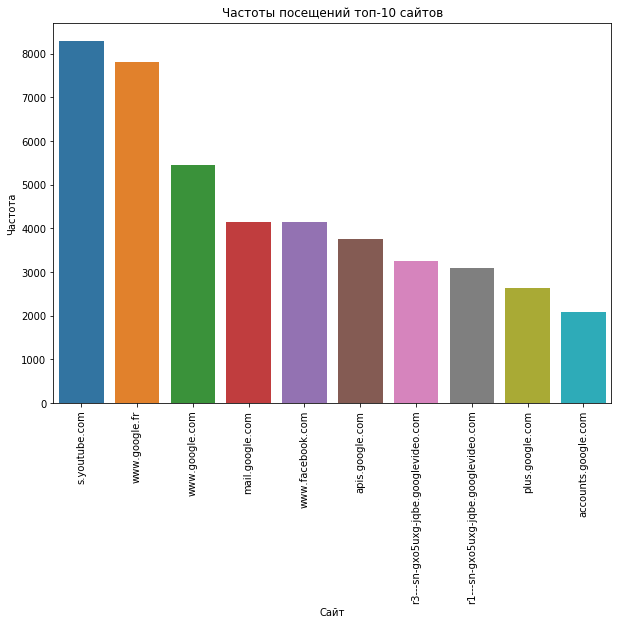

In [55]:
plt.figure(figsize=(10,7))
sns.barplot(x=top10_sites, y=top10_freqs)
plt.xlabel('Сайт')
plt.ylabel('Частота')
plt.xticks(rotation=90)
plt.title('Частоты посещений топ-10 сайтов')
plt.show()

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

Я добавил следующие признаки: istop30 - вхождение хотя бы одного сайта в сессии в топ30, issinglesite - вхождение хотя бы одного сайта-одиночки (с частотой 1 в словаре сайтов) в сессии, daytime - время суток начала сессии (утро, день вечер, ночь), isweekend - индикатор выходного дня (1 для сб и вс, для остальных дней - 0).

In [56]:
def feature_engineering(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    with open(site_freq_path, 'rb') as freq:
        dic = pickle.load(freq)
    top30 = np.arange(1, 30)
    singlesites = np.array([dic[k][0] for k in dic.keys() if dic[k][1] == 1])
    listcsv = glob(path_to_csv_files + '\*.csv')
    data = pd.DataFrame()
    rows = 0
    y_users = []
    for i, user in enumerate(listcsv):
        userid = int(user.split('\\')[-1][4:8])
        d = pd.read_csv(user)
        session = d.site.values
        session = np.array([dic[i][0] for i in session])
        time = d.timestamp.astype('datetime64[ns]').apply(lambda ts: 
                                                      ts.hour).astype('int').values
        dow = d.timestamp.astype('datetime64[ns]').apply(lambda ts: 
                                                      ts.isoweekday()).astype('int').values
        total = d.timestamp.astype('datetime64[ns]').apply(lambda ts: 
                                                      ts.timestamp()).astype('int').values
        k = (len(session) - 1) // window_size + 1
        rows += k
        a = np.zeros(len(feature_names))
        for j in range(k):
            s = session[j*window_size: j*window_size + session_length]
            unique_sites = np.unique(s).size
            istop30 = int(np.intersect1d(s, top30).size >= 1)
            issinglesite = int(np.intersect1d(s, singlesites).size >= 1)
            t = time[j*window_size: j*window_size + session_length]
            w = dow[j*window_size: j*window_size + session_length]
            tot = total[j*window_size: j*window_size + session_length]
            session_timespan = tot.max() - tot.min()
            start_hour = t.min()
            day_of_week = w.min() - 1
            if t.min() < 7:
                daytime = 1
            elif t.min() < 12:
                daytime = 2
            elif t.min() < 18:
                daytime = 3 
            else:
                daytime = 4 
            isweekend = w.min() // 6
            tot = tot[1:] - tot[:-1]
            if s.size < session_length:
                b = s.size
                s = np.hstack((s, [0]*(session_length - b)))
                tot = np.hstack((tot, [0]*(session_length - b)))
            a = np.vstack((a , np.hstack((s, tot, session_timespan, unique_sites, 
                                          start_hour, day_of_week, istop30, issinglesite, daytime, isweekend, userid))))
        data = pd.concat([data, pd.DataFrame(a[1:,:])]).astype('int')
    data.columns = feature_names
    data.index = np.arange(data.shape[0])
    return data

In [57]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'istop30', 'issinglesite', 'daytime', 'isweekend','target']

In [58]:
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

In [59]:
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [60]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

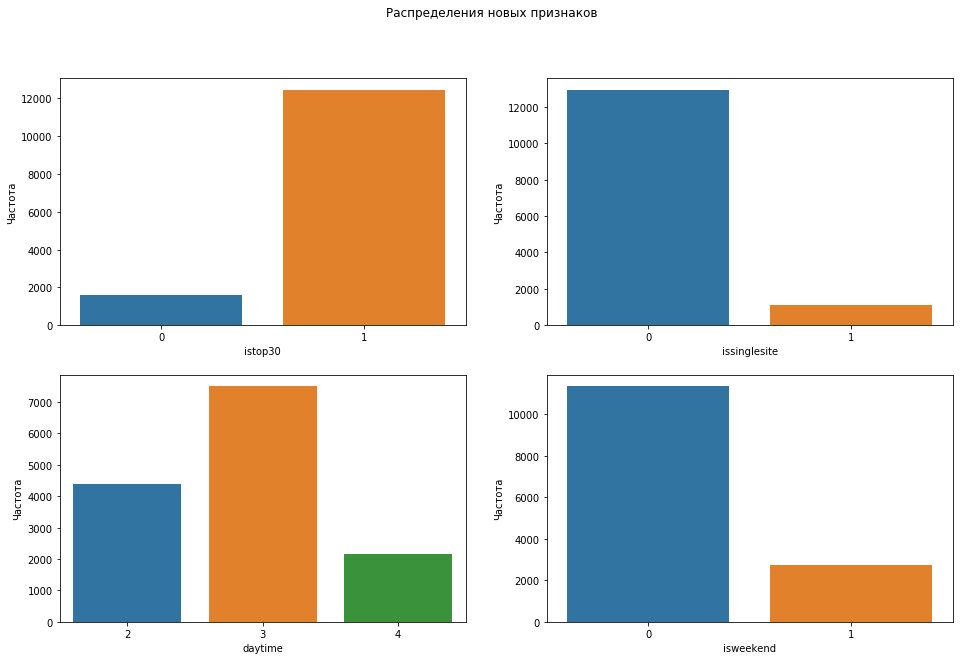

In [62]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
plt.suptitle('Распределения новых признаков')
for ax, name in zip(axes.flat, ['istop30', 'issinglesite', 'daytime', 'isweekend']):
    sns.countplot(new_features_10users[name], ax=ax)
    ax.set_xlabel(name)
    ax.set_ylabel('Частота')
plt.show()

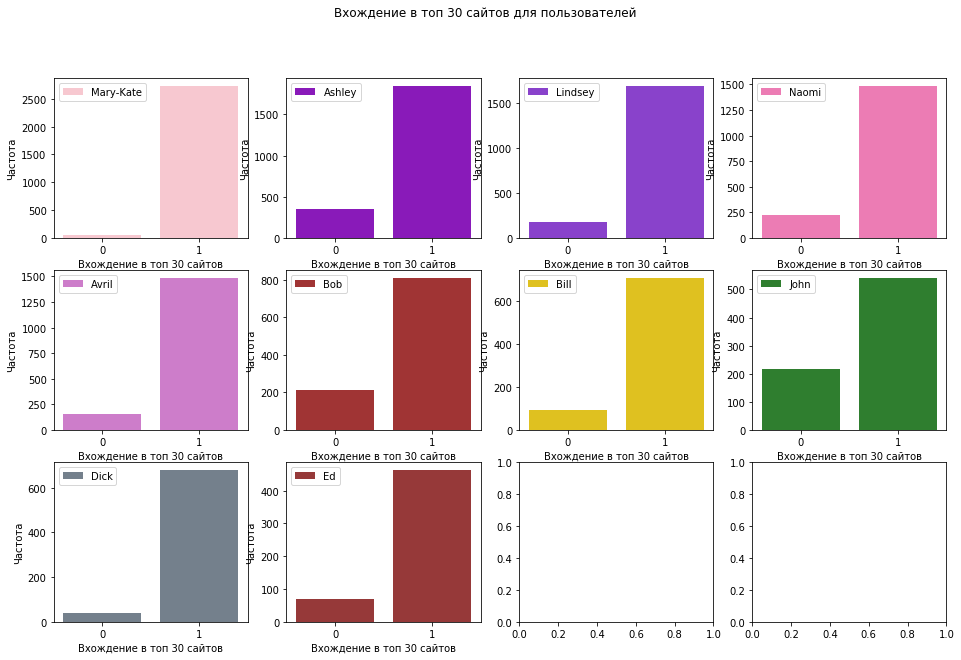

In [63]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.suptitle('Вхождение в топ 30 сайтов для пользователей')
for ax, name in zip(axes.flat[:10], color_dic.keys()):
    sns.countplot(new_features_10users[new_features_10users['target'] == name]['istop30'], ax=ax,  
                  color=color_dic[name], label=name)
    ax.set_xlabel('Вхождение в топ 30 сайтов')
    ax.set_ylabel('Частота')
    ax.legend()
plt.show()

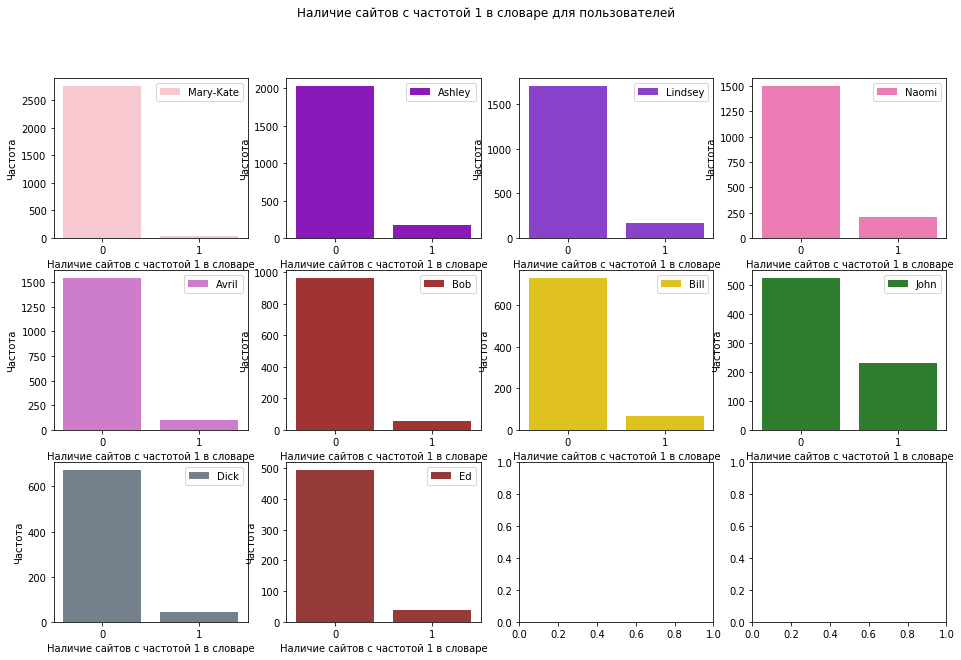

In [64]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.suptitle('Наличие сайтов с частотой 1 в словаре для пользователей')
for ax, name in zip(axes.flat[:10], color_dic.keys()):
    sns.countplot(new_features_10users[new_features_10users['target'] == name]['issinglesite'], ax=ax,  
                  color=color_dic[name], label=name)
    ax.set_xlabel('Наличие сайтов с частотой 1 в словаре')
    ax.set_ylabel('Частота')
    ax.legend()
plt.show()

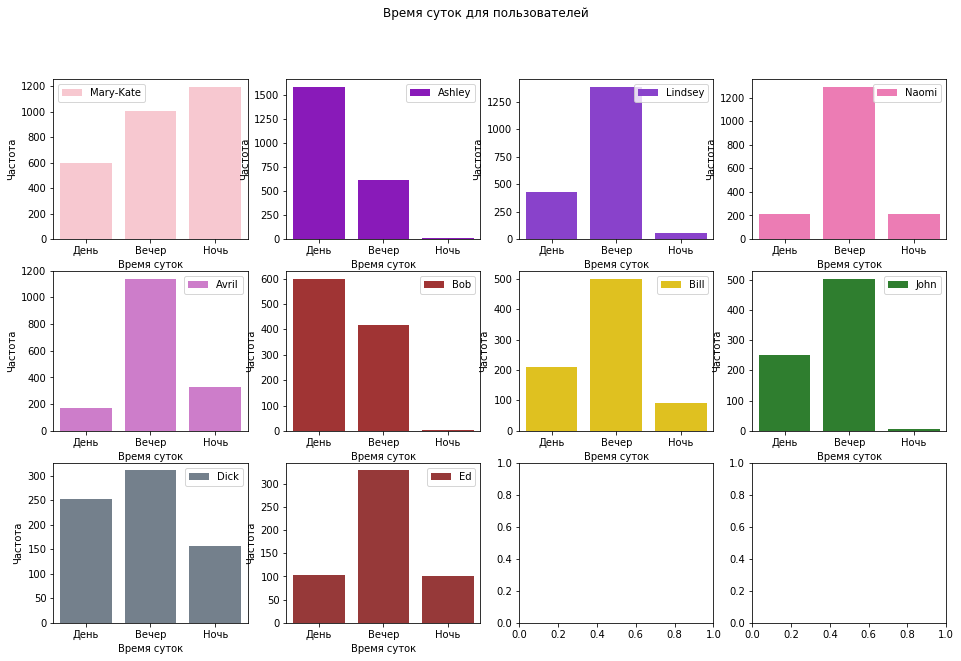

In [65]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.suptitle('Время суток для пользователей')
for ax, name in zip(axes.flat[:10], color_dic.keys()):
    sns.countplot(new_features_10users[new_features_10users['target'] == name]['daytime'], ax=ax,  
                  color=color_dic[name], label=name)
    ax.set_xlabel('Время суток')
    ax.set_ylabel('Частота')
    ax.legend()
    ax.set_xticklabels(labels = ['День', 'Вечер', 'Ночь'])
plt.show()

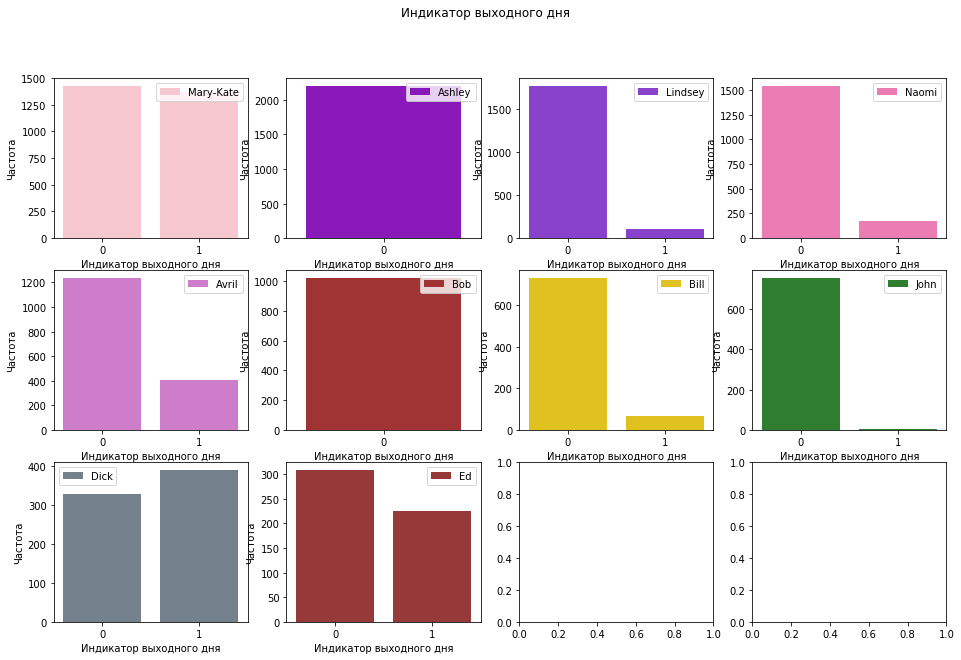

In [66]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
plt.suptitle('Индикатор выходного дня')
for ax, name in zip(axes.flat[:10], color_dic.keys()):
    sns.countplot(new_features_10users[new_features_10users['target'] == name]['isweekend'], ax=ax,  
                  color=color_dic[name], label=name)
    ax.set_xlabel('Индикатор выходного дня')
    ax.set_ylabel('Частота')
    ax.legend()
plt.show()

После анализа данных графиков можно сделать выводы о том, что новые признаки могут быть полезными при построении модели. Распределения этих принаков у различных пользователей отличаются. Во избежание переобучения можно использовать признаки daytime и isweekend вместо starthour и day_of_week  соответственно.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [152]:
selected_features_10users = new_features_10users[['session_timespan', '#unique_sites', 'istop30', 'issinglesite', 
                                                                  'daytime', 'isweekend']]
selected_features_150users = new_features_150users[['session_timespan', '#unique_sites', 'istop30', 'issinglesite', 
                                                                  'daytime', 'isweekend']]

In [153]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 